# Minneapolis Purple Air Sensor Project
## Elevation data wrangling ETL and QAQC

In [1]:
import arcpy # use arc pro objects and functions
from arcpy import env # to set working environmnet
import pandas as pd # manipulate data
import requests #fetch data from apis
import zipfile #compressed data
import io #data decoding
import numpy as np #make arrays out of rasters
import psycopg2 # manage sql and db connection
import os # file managment
from arcpy.ia import * # for merging rasters

### Set up environment

In [2]:
#set project directory path
proj_dir = r'C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc'
#set geodatabase path
proj_gdb = r'C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc\mpls_prplair_qaqc.gdb'
# set project aprx file path
aprx = arcpy.mp.ArcGISProject(r'C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc\mpls_prplair_qaqc.aprx')
#set arcpy environment, this is where this code will store the imported data
arcpy.env.workspace = proj_dir
# allow files to be overwritten
arcpy.env.overwriteOutput = True 
#test
arcpy.env.workspace

'C:\\Users\\MrJDF\\Desktop\\arc2_lab2\\mpls_prplair_qaqc'

###  define functions

In [3]:
# set up fnction to unzip requests and save to the project's working directory
def unzip(input_zipped, working_dir):
    get_zipped = zipfile.ZipFile(
        io.BytesIO(
            input_zipped.content)
    )
    
    get_zipped.extractall(working_dir)

In [4]:
# function to verify srs

def verify_srs(raster_in, expected_srs_name, expected_type):
    desc = arcpy.Describe(raster_in)
    srs = desc.spatialReference
    if srs.name == expected_srs_name and srs.type == expected_type:
        print('SRS OK', '\n', 'srs:', srs.name, '\n', 'type:', srs.type)

    else:
        print('ERROR: spatial reference system incompatible')

### Get the data

In [5]:
# set data url endpoint
base = r'https://resources.gisdata.mn.gov/pub/data/elevation/lidar/projects/metro/block_metro/geodatabase/'
# test set
gdb_list = [r'3542-31-22.gdb.zip',
            r'3542-31-23.gdb.zip',
]
## Uncomment the following list to process the entire aoi, data transfer will take time approx 15 min
# gdb_list = [r'3542-31-22.gdb.zip',
#             r'3542-31-23.gdb.zip',
#             r'3542-31-24.gdb.zip',
#             r'3542-31-25.gdb.zip',
#             r'3542-31-26.gdb.zip',
#             r'3542-31-27.gdb.zip',
#             r'3542-32-22.gdb.zip',
#             r'3542-32-23.gdb.zip',
#             r'3542-32-24.gdb.zip',
#             r'3542-32-25.gdb.zip',
#             r'3542-32-26.gdb.zip',
#             r'3542-32-27.gdb.zip',
#             r'4342-01-22.gdb.zip',
#             r'4342-01-23.gdb.zip',
#             r'4342-01-24.gdb.zip',
#             r'4342-01-25.gdb.zip',
#             r'4342-01-26.gdb.zip',
#             r'4342-01-27.gdb.zip',
#             r'4342-02-22.gdb.zip',
#             r'4342-02-23.gdb.zip',
#             r'4342-02-24.gdb.zip',
#             r'4342-02-25.gdb.zip',
#             r'4342-02-26.gdb.zip',
#             r'4342-02-27.gdb.zip',
#             r'4342-03-22.gdb.zip',
#             r'4342-03-23.gdb.zip',
#             r'4342-03-24.gdb.zip',
#             r'4342-03-25.gdb.zip',
#             r'4342-03-26.gdb.zip',
#             r'4342-03-27.gdb.zip',
#             r'4342-04-22.gdb.zip',
#             r'4342-04-23.gdb.zip',
#             r'4342-04-24.gdb.zip',
#             r'4342-04-25.gdb.zip',
#             r'4342-04-26.gdb.zip',
#             r'4342-04-27.gdb.zip',
#             r'4342-05-22.gdb.zip',
#             r'4342-05-23.gdb.zip',
#             r'4342-05-24.gdb.zip',
#             r'4342-05-25.gdb.zip',
#             r'4342-05-26.gdb.zip',
#             r'4342-05-27.gdb.zip',
#            ]

In [7]:
# fetch the data 
# estimated completion time 15 minutes
# uncomment to run

# for gdb in gdb_list:
#     response = requests.get(base + gdb)
#     unzip(response, proj_dir)

### Merge the raster tiles for consistency in analysis

In [8]:
# create a list of the new raster file names from the imported data
file_list_new = gdb_list

#intitiate empty list to hold input rasters
in_rasters = []

for i in range(len(file_list_new)):
    file_list_new[i] = file_list_new[i].replace(".zip", "") + "\dem_1m_m"
    
    # Create a new variable for each file using exec()
    exec(f'var_{i} = "{file_list_new[i]}"')
    
    # add that variable to the input rasters for the merge
    in_rasters.append(eval(f'var_{i}'))

In [9]:
# check the file name and format are correct
in_rasters

['3542-31-22.gdb\\dem_1m_m',
 '3542-31-23.gdb\\dem_1m_m',
 '3542-31-24.gdb\\dem_1m_m',
 '3542-31-25.gdb\\dem_1m_m',
 '3542-31-26.gdb\\dem_1m_m',
 '3542-31-27.gdb\\dem_1m_m',
 '3542-32-22.gdb\\dem_1m_m',
 '3542-32-23.gdb\\dem_1m_m',
 '3542-32-24.gdb\\dem_1m_m',
 '3542-32-25.gdb\\dem_1m_m',
 '3542-32-26.gdb\\dem_1m_m',
 '3542-32-27.gdb\\dem_1m_m',
 '4342-01-22.gdb\\dem_1m_m',
 '4342-01-23.gdb\\dem_1m_m',
 '4342-01-24.gdb\\dem_1m_m',
 '4342-01-25.gdb\\dem_1m_m',
 '4342-01-26.gdb\\dem_1m_m',
 '4342-01-27.gdb\\dem_1m_m',
 '4342-02-22.gdb\\dem_1m_m',
 '4342-02-23.gdb\\dem_1m_m',
 '4342-02-24.gdb\\dem_1m_m',
 '4342-02-25.gdb\\dem_1m_m',
 '4342-02-26.gdb\\dem_1m_m',
 '4342-02-27.gdb\\dem_1m_m',
 '4342-03-22.gdb\\dem_1m_m',
 '4342-03-23.gdb\\dem_1m_m',
 '4342-03-24.gdb\\dem_1m_m',
 '4342-03-25.gdb\\dem_1m_m',
 '4342-03-26.gdb\\dem_1m_m',
 '4342-03-27.gdb\\dem_1m_m',
 '4342-04-22.gdb\\dem_1m_m',
 '4342-04-23.gdb\\dem_1m_m',
 '4342-04-24.gdb\\dem_1m_m',
 '4342-04-25.gdb\\dem_1m_m',
 '4342-04-26.g

In [10]:
# merge raster tiles

mpls_metro_elev = arcpy.ia.Merge(in_rasters, "FIRST")
mpls_metro_elev.save("mpls_metro_elev.tif")

### Clip to Extent

In [23]:
# define extent of study (2km buffer around Mpls)
# Minneapolis Boundary (from MetCouncil CTUs and County Boundaries, must be downloaded to your current working directory)

# get boundary
mpls_bndry_path = os.path.join(os.getcwd(), 'mpls_boundary.geojson')
#TODO: Make this an api call to auto download the file if not present in cwd

# Specify the input GeoJSON file path
input_geojson = mpls_bndry_path
# Specify the output feature class path and name
output_fc = proj_gdb + r'\mpls_bndry'

# Convert the GeoJSON to feature class
arcpy.JSONToFeatures_conversion(input_geojson, output_fc)


ExecuteError: Failed to execute. Parameters are not valid.
ERROR 000732: Input JSON or GeoJSON: Dataset c:\Users\MrJDF\Desktop\QualityAirQualityCities\arcpy\qaqc\mpls_boundary.geojson does not exist or is not supported
WARNING 000725: Output Feature Class: Dataset C:\Users\MrJDF\Desktop\arc2_lab2\mpls_prplair_qaqc\mpls_prplair_qaqc.gdb\mpls_bndry already exists.
Failed to execute (JSONToFeatures).


### buffer

In [12]:
#buffer

# Specify the input feature class path and name
input_fc = output_fc
# Specify the output feature class path and name for the buffer
output_buffer = proj_gdb + r'\mpls_2km_buffer'

# Buffer the input feature class to 2km
arcpy.Buffer_analysis(input_fc, output_buffer, "2000 Meters")

<Result 'C:\\Users\\MrJDF\\Desktop\\arc2_lab2\\mpls_prplair_qaqc\\mpls_prplair_qaqc.gdb\\mpls_2km_buffer'>

### clip

In [13]:
# clip

# Set the input and output file paths
input_raster = r'mpls_metro_elev.tif'
output_raster = r'aoi_elev.tif'

#set extent
clipping_extent = output_buffer

# Clip the input raster to the clipping extent
arcpy.Clip_management(input_raster, clipping_extent, output_raster, "#", "#", "NONE")

<Result 'C:\\Users\\MrJDF\\Desktop\\arc2_lab2\\mpls_prplair_qaqc\\aoi_elev.tif'>

## Quality Checks

In [14]:
# create a raster object from the output to use as the main input variable for qaqc
dem = r'aoi_elev.tif'

### Visual Check for Logical Consistency, Completeness

In [ ]:
#TODO: add the clipped raster to the map

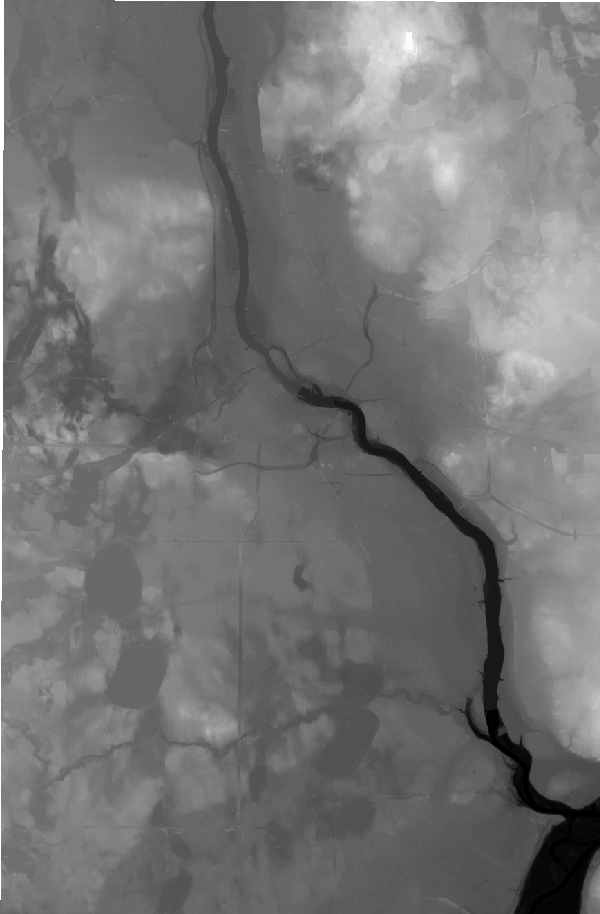

In [15]:
# display the raster in notebook

inRaster = dem

rendered_raster = arcpy.Render(inRaster, rendering_rule=
	{'bands': 1}, colormap ='gray')
rendered_raster

### Review File Attributes
- compatability and use

In [16]:
# Create a Describe object from the raster dataset to get object charatersitics
desc = arcpy.Describe(dem)

# Print some raster dataset properties
print("Band Count:       %d" % desc.bandCount)
print("Compression Type: %s" % desc.compressionType)
print("Raster Format:    %s" % desc.format)
#print("Permanent:        %s" % desc.permanent)
#print("Sensor Type:      %s" % desc.sensorType)

Band Count:       1
Compression Type: LZW
Raster Format:    TIFF


### Input Spatial Reference System Check

In [20]:
# Is the SRS correct and is it a projected type srs to ensure compatability with transformation to epsg 4326 for web maps

verify_srs(dem, 'NAD_1983_UTM_Zone_15N', 'Projected')

SRS OK 
 srs: NAD_1983_UTM_Zone_15N 
 type: Projected


### Transform raster srs from NAD_1983 sql friendly format (epsg 4326) WGS_84

In [18]:
#transform raster srs from NAD_1983 sql friendly format (epsg 4326) WGS_84

# set the output raster variable and the new spatial reference using a WKID
out_dem_4326 = r"aoi_elev_4326.tif"
new_srs = arcpy.SpatialReference(4326)  # WKID for WGS 84

# use the ProjectRaster_management function to project the raster
arcpy.ProjectRaster_management(dem, out_dem_4326, new_srs)

<Result 'C:\\Users\\MrJDF\\Desktop\\arc2_lab2\\mpls_prplair_qaqc\\aoi_elev_4326.tif'>

### Output Spatial Reference System Check

In [19]:
# Check the results

verify_srs(out_dem_4326, 'GCS_WGS_1984', 'Geographic')

SRS OK 
 srs: GCS_WGS_1984 
 type: Geographic


### No Data Check

In [21]:
# Check for any nodata values in the DEM

nodata = arcpy.sa.SetNull(out_dem_4326, out_dem_4326, "VALUE = {}".format(desc.noDataValue))
if arcpy.management.GetRasterProperties(nodata, "MAXIMUM") == 0:
    print("No nodata values found in DEM")
else:
    print("Nodata values found in DEM") # This is expected

Nodata values found in DEM


In [22]:
# make sure null value is set

#set file path for output
out_dem_null = r"aoi_elev_4326_null.tif"

# set the no data value to -3.4028231e+38
no_data_value = -3.4028231e+38

# use the SetNull function to convert the no data values to null values
out_raster = arcpy.sa.SetNull(arcpy.sa.Raster(out_dem_4326) == no_data_value, out_dem_4326)

# save the output raster to disk
out_raster.save(out_dem_null)

### Threshold Range Check
- is the data within a reasonale range for elevation in minnesota?

In [31]:
# Set the path to the raster dataset
raster_path = r"aoi_elev_4326_null.tif"

# Set the threshold values in meters
minimum_threshold = 200
maximum_threshold = 330

# Use the GetRasterProperties_management function to get the minimum and maximum values
desc = arcpy.GetRasterProperties_management(raster_path, "MINIMUM")
minimum_value = float(desc.getOutput(0))

desc = arcpy.GetRasterProperties_management(raster_path, "MAXIMUM")
maximum_value = float(desc.getOutput(0))

print('min value = ', minimum_value, '\n', 'max val = ', maximum_value)

#Check if the minimum and maximum values are within the threshold range
if minimum_value > minimum_threshold and maximum_value <= maximum_threshold:
    print("Minimum and maximum values are within the threshold range.")
else:
    print("WARNING: Minimum and maximum values are outside the threshold range.")

min value =  209.388000488281 
 max val =  329.877685546875
Minimum and maximum values are within the threshold range.


## Downsample Raster For Database Compatability
- the dem created above is approxamately 2.5 GB
- Here wee will downsample by a factor of 100 to save space and increase efficiency
- This is for the lab02 requirements only

- we should eventually only upload a small buffer around each sensor location for QAQC elevaton check puroposes in our official workflow

In [33]:
# Set the input raster file path
input_raster = r"aoi_elev_4326_null.tif"

# Set the output raster file path
output_raster = r"aoi_elev_4326_downsmpl.tif"

# Get the cell size of the input raster
desc = arcpy.Describe(input_raster)
cell_size = desc.meanCellWidth # or desc.meanCellHeight, depending on your analysis

# Set an appropriate cell size for the output raster
output_cell_size = cell_size * 100 # increase the cell size by a factor of 100

# Resample the input raster using bilinear interpolation
arcpy.Resample_management(input_raster, output_raster, output_cell_size, "BILINEAR")

<Result 'C:\\Users\\MrJDF\\Desktop\\arc2_lab2\\mpls_prplair_qaqc\\aoi_elev_4326_downsmpl.tif'>

## Create SQL tables in remote DB from raster data

- Use the Subprocess Library to run the raster to sql function in the notebook

In [34]:
import os
import subprocess
import sys

# Set the input raster file path and output PostGIS raster table name
input_raster = r"aoi_elev_4326_downsmpl.tif"
raster_table = "minneapolisDEM"

# Set the PostGIS connection parameters, Change this to your own settings
postgis_host = "34.133.237.115"
postgis_port = "5432"
postgis_user = "postgres"
postgis_password = "" 
postgis_db = "lab0"

# Set the SRID for the raster data
srid = "4269"

# Set the PATH environment variable for the subprocess
postgis_bin_path = r"C:\Program Files\PostgreSQL\15\bin"  # Replace <version> with your PostgreSQL version
os.environ["PATH"] = postgis_bin_path + os.pathsep + os.environ["PATH"]

# Set the PGPASSWORD environment variable for the raster2pgsql command
os.environ["PGPASSWORD"] = postgis_password

# Build the raster2pgsql command with the tiling option
raster2pgsql_cmd = f"raster2pgsql -s {srid} -I -C -M -t 128x128 {input_raster} -F {raster_table} | psql -h {postgis_host} -p {postgis_port} -U {postgis_user} -d {postgis_db}"

# Execute the raster2pgsql command
process = subprocess.run(raster2pgsql_cmd, shell=True, stderr=subprocess.PIPE, text=True)
if process.returncode != 0:
    print("An error occurred while running the raster2pgsql command:")
    print(process.stderr)
    sys.exit(1)

print("Raster data successfully imported to PostGIS.")

Raster data successfully imported to PostGIS.
